In [1]:
# importing required libraries

from pyspark.sql import SparkSession
from pyspark.sql import Row
import numpy as np
import pandas as pd
from pyspark.sql.types import *
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
from pyspark.sql import functions as fn
from pyspark.ml import feature, regression, evaluation, Pipeline
import seaborn as sns
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
spark = SparkSession.builder.getOrCreate()
from sklearn.metrics import classification_report
sc = spark.sparkContext
from pyspark.ml import Pipeline
from pyspark.ml.feature import  StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression

In [2]:
# Do not delete or change this cell

import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

In [3]:
# Reading the the csv file in us_acci dataframe
us_train = spark.read.csv(get_training_filename('USAccident_train_OHE.csv'), header = True, inferSchema = True)

In [4]:
# Reading the the csv file in us_acci dataframe
us_test = spark.read.csv(get_training_filename('USAccident_validation_OHE.csv'), header = True, inferSchema = True)

In [5]:
# Converts the train data with Severity 3 and 4 to 1 and rest to 0
us_train=us_train.withColumn("Severity",when(((us_train["Severity"]==4) | (us_train["Severity"]==3)),1).otherwise(0))

In [6]:
# Converts the test data with Severity 3 and 4 to 1 and rest to 0
us_test=us_test.withColumn("Severity",when(((us_test["Severity"]==4) | (us_test["Severity"]==3)),1).otherwise(0))

In [7]:
# Declaring the vector assembler
va = VectorAssembler().setInputCols([i for i in us_train.columns if i!='Severity']).setOutputCol('features')

In [8]:
# Centering the data
center = feature.StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='centered_features')

In [9]:
# Converting the categorical columns with string to numerical labels
label_stringIdx = StringIndexer(inputCol="Severity", outputCol="label")

# LR Binary Base Model

In [10]:
# Create initial LogisticRegression model
lr_w = LogisticRegression(labelCol="label", featuresCol="centered_features")

# Train model with Training Data
lrModel_w = Pipeline(stages=[label_stringIdx,va, center, lr_w])

# Fits the model
lr_fit_w = lrModel_w.fit(us_train)

In [11]:
# Performs the prediiction on test set
pred_lrb = lr_fit_w.transform(us_test)

In [12]:
# Caculates the accuracy for binary data
true_labels=us_test.toPandas()["Severity"]
binary_prediction=lr_fit_w.transform(us_test).select("prediction").collect()
binary_true_labels=us_test.select("Severity").collect()
print("Accuracy:",np.sum(list([int(binary_true_labels[i][0]==binary_prediction[i][0]) for i in range(len(true_labels))]))/len(true_labels))

Accuracy: 0.7213747454175152


In [13]:
# Using the evaluator to calculate the AUC ROC
evaluator_lrb = BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC')
print('Test Area Under ROC', evaluator_lrb.evaluate(pred_lrb))

Test Area Under ROC 0.7621852339529867


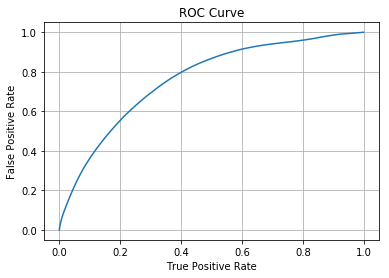

Training set areaUnderROC: 0.7621682343009717


In [14]:
trainingSummary = lr_fit_w.stages[-1].summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [18]:
lr_fit_w.stages[-1].getRegParam()

0.0

In [19]:
lr_fit_w.stages[-1].getElasticNetParam()

0.0

In [15]:
prediction_lrb=(pred_lrb).toPandas()["prediction"]

In [16]:
true_labels=us_test.toPandas()["Severity"]

In [17]:
# Classification report for calculating the metrics
print(classification_report(y_pred=prediction_lrb,y_true=true_labels))

              precision    recall  f1-score   support

           0       0.74      0.91      0.81    131790
           1       0.65      0.34      0.44     64610

   micro avg       0.72      0.72      0.72    196400
   macro avg       0.69      0.62      0.63    196400
weighted avg       0.71      0.72      0.69    196400



In [18]:
# stores all the co-efficients of the logistic regression
coef_L1_m=lr_fit_w.stages[-1].coefficients.toArray()

In [19]:
# makes a datafram of the coefficients
feat_imp_tuned_lrt = pd.DataFrame(list(zip([i for i in us_train.columns if i!='Severity'], coef_L1_m)),
            columns = ['column', 'weight']).sort_values('weight')

In [20]:
# Printing the number of feature eliminated
coef_L1_m = np.absolute(coef_L1_m)
print('Total number of features are',len(coef_L1_m))
sorted_abs = np.sort(coef_L1_m)
weights_notzero = sorted_abs[sorted_abs == 0]
nonzero_weights = len(sorted_abs[sorted_abs == 0])
print('Eliminated features out of ' + str(len(coef_L1_m)) + ' are', len(weights_notzero))

Total number of features are 120
Eliminated features out of 120 are 0


# LR Binary Grid Search Model

In [21]:
lr_new = LogisticRegression(labelCol="label", featuresCol="centered_features")

In [22]:
# Define a grid for tuning the algorithm
#paramGrid_lr = ParamGridBuilder().addGrid(lr_new.regParam, [0.01, 0.8,0.03]).addGrid(lr_new.elasticNetParam, [0.1,0.4,0.7]).build()
paramGrid_lr = ParamGridBuilder().addGrid(lr_new.regParam, [0.01]).addGrid(lr_new.elasticNetParam, [0.1]).build()

In [23]:
# Making the pipeline for prediction
cvModel_lrmu = Pipeline(stages=[label_stringIdx,va,center,lr_new])

In [24]:
# Defining a evaluator for evaluating our prediction
evaluator_lrbt = BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC')

In [25]:
# Defining the cross validator for model
cv = CrossValidator(estimator=cvModel_lrmu, estimatorParamMaps=paramGrid_lr, evaluator=evaluator_lrbt, numFolds=5).fit(us_train)

In [26]:
# Makes prediction on test set
pred_lrbt = cv.transform(us_test)

In [27]:
evaluator_lrb = BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC')
print('Test Area Under ROC', evaluator_lrb.evaluate(pred_lrbt))

Test Area Under ROC 0.7615211426502622


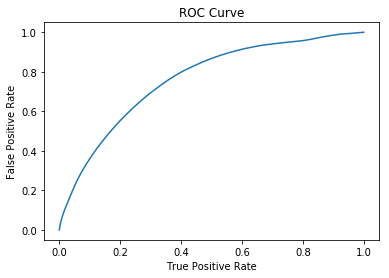

Training set areaUnderROC: 0.7616980707233938


In [28]:
trainingSummary_t = cv.bestModel.stages[-1].summary
roc = trainingSummary_t.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary_t.areaUnderROC))

In [42]:
cv.bestModel.stages[-1].getRegParam()

0.01

In [43]:
cv.bestModel.stages[-1].getElasticNetParam()

0.1

In [ ]:
cv.bestModel.stages[-1].extractParamMap()

In [29]:
prediction_lrbt=(pred_lrbt).toPandas()["prediction"]

In [30]:
true_labels=us_test.toPandas()["Severity"]

In [31]:
from sklearn.metrics import classification_report

In [32]:
print(classification_report(y_pred=prediction_lrbt,y_true=true_labels))

              precision    recall  f1-score   support

           0       0.73      0.92      0.81    131790
           1       0.66      0.31      0.42     64610

   micro avg       0.72      0.72      0.72    196400
   macro avg       0.69      0.62      0.62    196400
weighted avg       0.71      0.72      0.69    196400



In [33]:
# calculates the accuracy
true_labels=us_test.toPandas()["Severity"]
evaluator_lrbt.evaluate(pred_lrbt)
binary_prediction=pred_lrbt.select("prediction").collect()
binary_true_labels=us_test.select("Severity").collect()
print("Accuracy:",np.sum(list([int(binary_true_labels[i][0]==binary_prediction[i][0]) for i in range(len(true_labels))]))/len(true_labels))

Accuracy: 0.7195977596741344


In [34]:
# stores all coefficients of the LR model
coef_L1_m=cv.bestModel.stages[-1].coefficients.toArray()

In [35]:
# Makes a dataframe of the variables and their respective coefficients
feat_imp_tuned_lrt = pd.DataFrame(list(zip([i for i in us_train.columns if i!='Severity'], coef_L1_m)),
            columns = ['column', 'weight']).sort_values('weight')

In [36]:
#  Shows the number of features that our LR model eliminated
coef_L1_m = np.absolute(coef_L1_m)
print('Total number of features are',len(coef_L1_m))
sorted_abs = np.sort(coef_L1_m)
weights_notzero = sorted_abs[sorted_abs == 0]
nonzero_weights = len(sorted_abs[sorted_abs == 0])
print('Eliminated features out of ' + str(len(coef_L1_m)) + ' are', len(weights_notzero))

Total number of features are 120
Eliminated features out of 120 are 28
